Este cuadernillo contiene todo el código empleado para realizar la parte de nuestro TFM relativa al análisis del dataset Youtube Video Trending Dataset. Incluye las siguientes secciones:

- Instalación de subprogramas y librerías
- Preprocesamiento de los datos
- Obtención y análisis de características de los datos

## Instalación de subprogramas y librerías

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import isodate #para manejar formato de duración ISO 8601
import re #para manejar expresiones regulares
from textblob import TextBlob
from lingua import Language, LanguageDetectorBuilder

## Preprocesamiento de datos

In [37]:
# PASO 1: LECTURA DEL ARCHIVO
df = pd.read_csv("videos_virales_final_plus.csv", low_memory=False)

In [38]:
# El primer paso del preprocesado es eliminar columnas que consideramos innecesarias para el estudio. Estas son: 
# channel_id,video_dimension, channel_have_hidden_subscribers, channel_localized_title, channel_localized_description
elim_columns = ['channel_id','video_dimension', 'channel_have_hidden_subscribers', 'channel_localized_title', 'channel_localized_description']
df = df.drop(columns=elim_columns)

In [39]:
#Debemos eliminar las filas con video_id nulo, ya que esa será la variable principal para la identificación de los vídeos.
#Según los metadatos ofrecidos por Kaggle, hay 13 instancias de ese tipo.
df = df.dropna(subset=['video_id'])

In [40]:
#A continuación trataremos el resto de valores NaN.
#Para columnas alfanuméricas (string), cambiar por ""
#Para columnas numéricas,
alfanumeric_values = {"video_trending_country": "", "video_description": "", "video_category_id": "", "video_tags": ""}

#de momento no

In [41]:
#Guardamos el dataset resultante en un csv para evitar repetir el proceso
df.to_csv('ytvg_clean.csv', index=False)

In [42]:
#Creamos un dataset auxiliar que contenga solamente una instancia de cada vídeo. Es decir, deberá tener unas 180.000 instancias.
df_unique = df.drop_duplicates(subset=['video_id'], keep='first')
df_unique.to_csv('ytvg_unique.csv', index=False)

## Obtención y análisis de características

In [43]:
df = pd.read_csv("ytvg_unique.csv")

C:\Users\ruben\AppData\Local\Temp\ipykernel_5348\428362058.py:1: DtypeWarning: Columns (23,26,27,32,34,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("ytvg_unique.csv")


In [44]:
df.columns

Index(['video_id', 'video_published_at', 'video_trending__date',
       'video_trending_country', 'video_title', 'video_description',
       'video_default_thumbnail', 'video_category_id', 'video_tags',
       'video_duration', 'video_definition', 'video_licensed_content',
       'video_view_count', 'video_like_count', 'video_comment_count',
       'channel_title', 'channel_description', 'channel_custom_url',
       'channel_published_at', 'channel_country', 'channel_view_count',
       'channel_subscriber_count', 'channel_video_count', 'thumbnail_url_hq',
       'title_length', 'title_word_count', 'title_has_exclamation',
       'title_has_question', 'title_uppercase_ratio', 'title_sentiment',
       'description_length', 'description_sentiment', 'has_external_links',
       'tag_count', 'published_at', 'hour_of_day', 'day_of_week', 'is_weekend',
       'is_peak_hour', 'video_duration_sec', 'thumbnail_text_count',
       'thumbnail_colorfulness', 'thumbnail_faces_count', 'views_per_se

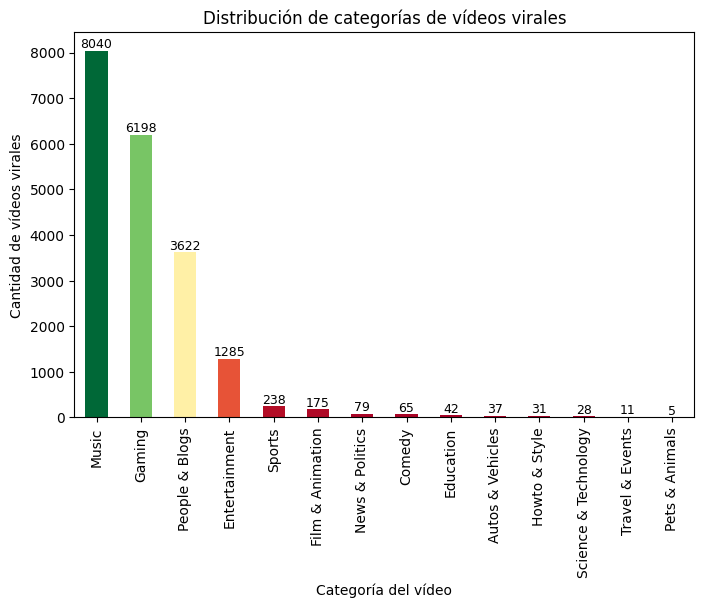

In [45]:
#Análisis de categorías
categories = df['video_category_id'].value_counts()
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de categorías de vídeos virales")
plt.xlabel("Categoría del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [46]:
#Análisis de duración. Formato de la duración: ISO 8601
#Transformar todas las duraciones a segundos.
df["video_duration_segs"] = df["video_duration"].apply(lambda x: int(isodate.parse_duration(x).total_seconds()))
df["video_duration_segs"].describe()

count    19866.000000
mean      2886.407228
std       6250.605501
min          6.000000
25%        202.250000
50%        472.000000
75%       1817.750000
max      73561.000000
Name: video_duration_segs, dtype: float64

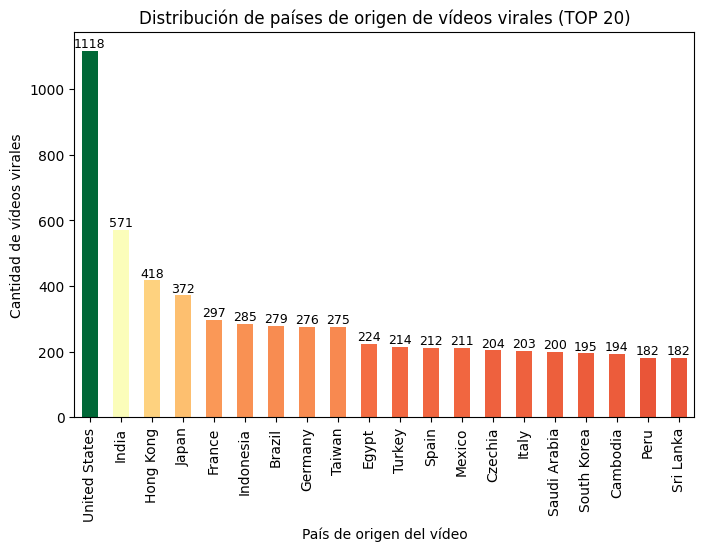

In [47]:
#País de origen de los vídeos
categories = df['channel_country'].value_counts()
categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de países de origen de vídeos virales (TOP 20)")
plt.xlabel("País de origen del vídeo")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [48]:
#Columnas para el idioma
languages = [Language.ENGLISH, Language.FRENCH, Language.GERMAN, Language.SPANISH, Language.ITALIAN, Language.PORTUGUESE, Language.ARABIC, Language.THAI, Language.HINDI, Language.CHINESE, Language.INDONESIAN, Language.RUSSIAN, Language.POLISH, Language.JAPANESE]
detector = LanguageDetectorBuilder.from_languages(*languages).with_preloaded_language_models().build()
#detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()
df['video_title_language'] = df['video_title'].apply(lambda x: str(detector.detect_language_of(str(x)))[9:])
df['vtl_confidence'] =  df['video_title'].apply(lambda x: detector.compute_language_confidence_values(str(x))[0].value)

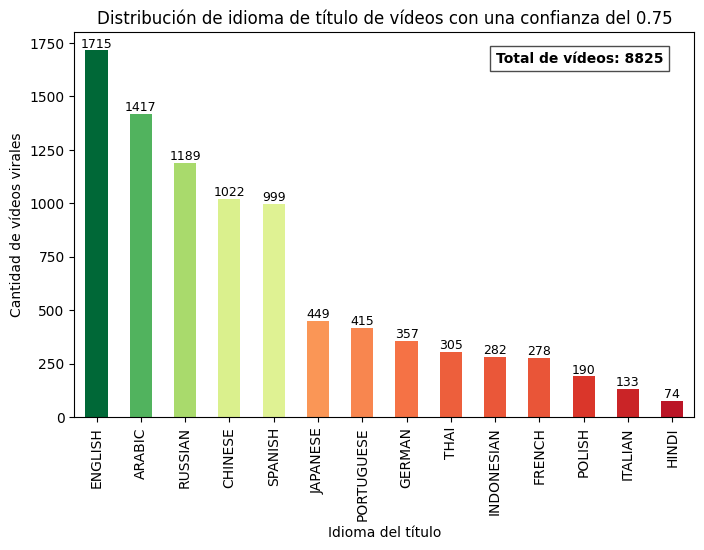

In [53]:
#Idioma de los títulos
confianza = 0.75
categories = df[df['vtl_confidence'] >= confianza]['video_title_language'].value_counts()
#categories = categories[0:20]
plt.figure(figsize=(8,5))
bars = categories.plot(kind='bar', color=plt.cm.RdYlGn(categories/categories.max()))

plt.title(f"Distribución de idioma de título de vídeos con una confianza del {confianza}")
plt.xlabel("Idioma del título")
plt.ylabel("Cantidad de vídeos virales")
plt.xticks(rotation=90)

plt.text(0.95, 0.95, f"Total de vídeos: {categories.sum()}", 
         ha="right", va="top", transform=plt.gca().transAxes,
         fontsize=10, fontweight="bold", bbox=dict(facecolor="white", alpha=0.7))

for i, value in enumerate(categories):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=9)

plt.show()

In [52]:
df["video_title_len"] = df["video_title"].apply(lambda x: len(x))
df["title_word_count"]

0        16.0
1         8.0
2         6.0
3         8.0
4        11.0
         ... 
19861     NaN
19862     NaN
19863     NaN
19864     NaN
19865     NaN
Name: title_word_count, Length: 19866, dtype: float64

In [18]:
len(df["video_title"][0])

68

In [54]:
#Análisis de título (idioma, tamaño, emojis)
df

,video_id,video_published_at,video_trending__date,video_trending_country,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,video_duration,...,views_per_second,likes_per_view,likes_per_sub,views_per_sub,viral_score,is_viral,video_duration_segs,video_title_language,vtl_confidence,video_title_len
0,2ttVjSrLEZE,2024-10-02T15:00:27Z,2024.10.12,United Arab Emirates,Ayed - Ma Hada Bali | Official Music Video 202...,للإشتراك في القناة | https://rb.gy/7wjde8\nللا...,https://i.ytimg.com/vi/2ttVjSrLEZE/default.jpg,Music,"Ayed,Ayedh Yousef,Ma Hada Bali,أجدد الأغاني ال...",PT5M1S,...,5407.291391,0.019319,2.175574,112.613061,114.807954,1.0,301,ENGLISH,0.408419,68
1,cyCfVb0_FZg,2024-09-26T16:00:22Z,2024.10.12,Bulgaria,SHUNAKA - Mr.DaiMiPariteSi [OFFICIAL 4K VIDEO]...,Subscribe to Shunaka: https://bit.ly/3Mt8U6h\n...,https://i.ytimg.com/vi/cyCfVb0_FZg/default.jpg,Music,"shunaka,dsd,dim4ou,vrgo,virgo,trf,boro,purvi,p...",PT2M40S,...,1106.779343,0.029299,3.486623,119.002524,122.518446,1.0,160,ENGLISH,0.486808,51
2,O2XDDmyuycw,2024-09-27T07:00:06Z,2024.10.12,Bulgaria,Robi - Тихо (Official Video),"""Тихо, тихо, тихо... оставам с тебе""\n\nПърва ...",https://i.ytimg.com/vi/O2XDDmyuycw/default.jpg,Music,"роби,robi,tiho,tiho tiho,molec,молец,тихо,тихо...",PT2M53S,...,2228.600000,0.053797,51.048662,948.917275,1000.019733,1.0,173,ENGLISH,0.320152,28
3,IoHXh4oGZM8,2024-09-22T08:08:44Z,2024.10.12,Bosnia and Herzegovina,"September 22, 2024",NaN,https://i.ytimg.com/vi/IoHXh4oGZM8/default.jpg,Entertainment,NaN,PT39S,...,5743.062500,0.002704,0.150106,55.505285,55.658095,1.0,39,INDONESIAN,0.471172,18
4,nPBCrqxz30w,2024-09-17T16:00:45Z,2024.10.12,Bosnia and Herzegovina,Ja sa 32 i 102 godine😂,Dobro došli u život jedne prosečne balkanske p...,https://i.ytimg.com/vi/nPBCrqxz30w/default.jpg,People & Blogs,NaN,PT13S,...,66.502612,0.019381,0.186880,9.642148,9.848410,1.0,13,FRENCH,0.182891,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19861,7LQNGpM6KaE,2025-09-03T12:16:07Z,2025.09.03,Cambodia,ដល់ពេលហើយដែលខ្ញុំត្រូវ..... #vtb #gtav #fivem ...,💗DONATION:\n👉ABA KH QR: https://pay.ababank.co...,https://i.ytimg.com/vi/7LQNGpM6KaE/default_liv...,Gaming,"feeling good,game time,gameplay,chilling game,...",PT1H22M26S,...,NaN,NaN,NaN,NaN,NaN,NaN,4946,ENGLISH,0.304618,55
19862,b87vuxs2lJo,2025-09-03T12:01:10Z,2025.09.03,Cambodia,រឿង ​Novel គុជអមតៈធៀននី​ Ep775-776 | សម្រាយរឿង...,រឿង ​Novel គុជអមតៈធៀននី​ Ep775-776 | សម្រាយរឿង...,https://i.ytimg.com/vi/b87vuxs2lJo/default.jpg,Film & Animation,"សម្រាយរឿង គុជអមតះធៀននី,សម្រាយរឿង renegade Immo...",PT24M49S,...,NaN,NaN,NaN,NaN,NaN,NaN,1489,SPANISH,0.376266,79
19863,yym1ObqbB3s,2025-09-03T11:00:35Z,2025.09.03,Cambodia,🔴LIVE |​ Hello all my Cutie welcome to my live...,Donation : https://link.payway.com.kh/ABAPAYQk...,https://i.ytimg.com/vi/yym1ObqbB3s/default_liv...,Gaming,NaN,PT1H55M36S,...,NaN,NaN,NaN,NaN,NaN,NaN,6936,ENGLISH,0.603595,58
19864,zwSDuWh1xYQ,2025-09-03T06:42:07Z,2025.09.03,Cambodia,Hello កូនប៉ា ប៉ា,Donate Here: \nAccount-holder name: SENG PHEAK...,https://i.ytimg.com/vi/zwSDuWh1xYQ/default.jpg,Gaming,"Bong Barang,bongbarang,pes mobile,pes live,pes...",PT3H57M24S,...,NaN,NaN,NaN,NaN,NaN,NaN,14244,ITALIAN,0.358548,16


## Preprocesamiento títulos - análisis de sentimientos

In [55]:
#funcion para extraer algunas características del título
def extract_features(df):
    df['title_length'] = df['video_title'].apply(lambda x: len(str(x)))
    df['title_word_count'] = df['video_title'].apply(lambda x: len(str(x).split()))
    df['title_has_exclamation'] = df['video_title'].apply(lambda x: '!' in str(x))
    df['title_has_question'] = df['video_title'].apply(lambda x: '?' in str(x))
    df['title_sentiment'] = df['video_title'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    df['description_length'] = df['video_description'].apply(lambda x: len(str(x)))
    df['description_sentiment'] = df['video_description'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    return df

In [56]:
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes y peligrosas para evitar fuga de datos
# Explicación:
# Eliminamos identificadores, URLs, descripciones redundantes, el target y cualquier variable derivada del target.
# Así evitamos fuga de datos y aseguramos que el modelo solo use información disponible antes de saber si un vídeo es viral.
# No eliminamos variables originales del vídeo/canal ni features extraídas del texto.

# Preprocesado para predicción antes de publicar
# Elimina TODAS las variables de interacción y métricas post-publicación
cols_to_drop = [
    'video_id', 'channel_id', 'video_default_thumbnail', 'thumbnail_url_hq',
    'channel_title', 'channel_description', 'channel_custom_url',
    'channel_localized_title', 'channel_localized_description', 'published_at',
    'is_viral', 'viral_score',  # targets
    'video_view_count', 'video_like_count', 'video_comment_count',
    'views_per_second', 'likes_per_view', 'likes_per_sub', 'views_per_sub','views_per_subscriber',
    'channel_view_count', 'channel_subscriber_count', 'channel_video_count'
]
cols_to_drop += ['video_tags', 'channel_country']
df_preproc_clf = df.copy()
df_preproc_clf = extract_features(df_preproc_clf)
df_preproc_clf.drop(columns=[col for col in cols_to_drop if col in df_preproc_clf.columns], inplace=True)

# Eliminar columnas con todos los valores NaN antes de imputar
cols_all_nan = [col for col in df_preproc_clf.columns if df_preproc_clf[col].isna().all()]
df_preproc_clf.drop(columns=cols_all_nan, inplace=True)

# Imputar nulos y codificar categóricas
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown').astype(str)
    from sklearn.preprocessing import LabelEncoder
    df_preproc_clf[col] = LabelEncoder().fit_transform(df_preproc_clf[col])
for col in num_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna(df_preproc_clf[col].median())

# Eliminar columnas constantes antes de escalar
from pandas.api.types import is_numeric_dtype
cols_constant = [col for col in df_preproc_clf.columns if is_numeric_dtype(df_preproc_clf[col]) and df_preproc_clf[col].nunique() <= 1]
df_preproc_clf.drop(columns=cols_constant, inplace=True)

# Estandarizar numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_preproc_clf[num_cols] = scaler.fit_transform(df_preproc_clf[num_cols])

In [58]:
# Eliminar filas donde el target 'is_viral' sea NaN antes de continuar el preprocesado
if 'is_viral' in df.columns:
    df = df.dropna(subset=['is_viral']).reset_index(drop=True)

# ...continúa el preprocesado habitual...
df_preproc = df
df_preproc = extract_features(df_preproc)

# 2. Eliminar columnas irrelevantes y peligrosas para evitar fuga de datos
# Explicación:
# Eliminamos identificadores, URLs, descripciones redundantes, el target y cualquier variable derivada del target.
# Así evitamos fuga de datos y aseguramos que el modelo solo use información disponible antes de saber si un vídeo es viral.
# No eliminamos variables originales del vídeo/canal ni features extraídas del texto.

# Preprocesado para predicción antes de publicar
# Elimina TODAS las variables de interacción y métricas post-publicación
cols_to_drop = [
    'video_id', 'channel_id', 'video_default_thumbnail', 'thumbnail_url_hq',
    'channel_title', 'channel_description', 'channel_custom_url',
    'channel_localized_title', 'channel_localized_description', 'published_at',
    'is_viral', 'viral_score',  # targets
    'video_view_count', 'video_like_count', 'video_comment_count',
    'views_per_second', 'likes_per_view', 'likes_per_sub', 'views_per_sub','views_per_subscriber',
    'channel_view_count', 'channel_subscriber_count', 'channel_video_count'
]
cols_to_drop += ['video_tags', 'channel_country']
df_preproc_clf = df.copy()
df_preproc_clf = extract_features(df_preproc_clf)
df_preproc_clf.drop(columns=[col for col in cols_to_drop if col in df_preproc_clf.columns], inplace=True)

# Eliminar columnas con todos los valores NaN antes de imputar
cols_all_nan = [col for col in df_preproc_clf.columns if df_preproc_clf[col].isna().all()]
df_preproc_clf.drop(columns=cols_all_nan, inplace=True)

# Imputar nulos y codificar categóricas
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df_preproc_clf.select_dtypes(include='object').columns
for col in cat_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown').astype(str)
    from sklearn.preprocessing import LabelEncoder
    df_preproc_clf[col] = LabelEncoder().fit_transform(df_preproc_clf[col])
for col in num_cols:
    df_preproc_clf[col] = df_preproc_clf[col].fillna(df_preproc_clf[col].median())

# Eliminar columnas constantes antes de escalar
from pandas.api.types import is_numeric_dtype
cols_constant = [col for col in df_preproc_clf.columns if is_numeric_dtype(df_preproc_clf[col]) and df_preproc_clf[col].nunique() <= 1]
df_preproc_clf.drop(columns=cols_constant, inplace=True)

# Estandarizar numéricas
from sklearn.preprocessing import StandardScaler
num_cols = df_preproc_clf.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()
df_preproc_clf[num_cols] = scaler.fit_transform(df_preproc_clf[num_cols])

C:\Users\ruben\AppData\Local\Temp\ipykernel_5348\2440085197.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown').astype(str)
C:\Users\ruben\AppData\Local\Temp\ipykernel_5348\2440085197.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_preproc_clf[col] = df_preproc_clf[col].fillna('Unknown').astype(str)
C:\Users\ruben\AppData\Local\Temp\ipykernel_5348\2440085197.py:39: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version

In [59]:
df_preproc

,video_id,video_published_at,video_trending__date,video_trending_country,video_title,video_description,video_default_thumbnail,video_category_id,video_tags,video_duration,...,views_per_second,likes_per_view,likes_per_sub,views_per_sub,viral_score,is_viral,video_duration_segs,video_title_language,vtl_confidence,video_title_len
0,2ttVjSrLEZE,2024-10-02T15:00:27Z,2024.10.12,United Arab Emirates,Ayed - Ma Hada Bali | Official Music Video 202...,للإشتراك في القناة | https://rb.gy/7wjde8\nللا...,https://i.ytimg.com/vi/2ttVjSrLEZE/default.jpg,Music,"Ayed,Ayedh Yousef,Ma Hada Bali,أجدد الأغاني ال...",PT5M1S,...,5407.291391,0.019319,2.175574,112.613061,114.807954,1.0,301,ENGLISH,0.408419,68
1,cyCfVb0_FZg,2024-09-26T16:00:22Z,2024.10.12,Bulgaria,SHUNAKA - Mr.DaiMiPariteSi [OFFICIAL 4K VIDEO]...,Subscribe to Shunaka: https://bit.ly/3Mt8U6h\n...,https://i.ytimg.com/vi/cyCfVb0_FZg/default.jpg,Music,"shunaka,dsd,dim4ou,vrgo,virgo,trf,boro,purvi,p...",PT2M40S,...,1106.779343,0.029299,3.486623,119.002524,122.518446,1.0,160,ENGLISH,0.486808,51
2,O2XDDmyuycw,2024-09-27T07:00:06Z,2024.10.12,Bulgaria,Robi - Тихо (Official Video),"""Тихо, тихо, тихо... оставам с тебе""\n\nПърва ...",https://i.ytimg.com/vi/O2XDDmyuycw/default.jpg,Music,"роби,robi,tiho,tiho tiho,molec,молец,тихо,тихо...",PT2M53S,...,2228.600000,0.053797,51.048662,948.917275,1000.019733,1.0,173,ENGLISH,0.320152,28
3,IoHXh4oGZM8,2024-09-22T08:08:44Z,2024.10.12,Bosnia and Herzegovina,"September 22, 2024",NaN,https://i.ytimg.com/vi/IoHXh4oGZM8/default.jpg,Entertainment,NaN,PT39S,...,5743.062500,0.002704,0.150106,55.505285,55.658095,1.0,39,INDONESIAN,0.471172,18
4,nPBCrqxz30w,2024-09-17T16:00:45Z,2024.10.12,Bosnia and Herzegovina,Ja sa 32 i 102 godine😂,Dobro došli u život jedne prosečne balkanske p...,https://i.ytimg.com/vi/nPBCrqxz30w/default.jpg,People & Blogs,NaN,PT13S,...,66.502612,0.019381,0.186880,9.642148,9.848410,1.0,13,FRENCH,0.182891,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,dFny3a-4Jr4,2025-02-17T08:41:35Z,2025.02.18,Italy,CARLO VERDONE | Il saluto a Lucio Corsi | HOT ...,Il videomessaggio di complimenti di Carlo Verd...,https://i.ytimg.com/vi/dFny3a-4Jr4/default.jpg,Film & Animation,"cinema,film,trailer,movie,video,backstage,vide...",PT1M16S,...,0.875688,0.194794,0.050689,0.259986,0.505469,0.0,76,ITALIAN,0.742540,50
803,KTGbyaW5bRc,2025-02-17T10:15:06Z,2025.02.18,Japan,【あわや大惨事】車体がぼろぼろになっても止まらない車 運転手は飲酒をしていた可能性も 幸いけ...,2月16日午後2時45分ごろ、島根県浜田市下府町の住宅街で撮影された映像には、住宅の塀にぶつ...,https://i.ytimg.com/vi/KTGbyaW5bRc/default.jpg,News & Politics,"日本海テレビ,news every,One,One LIFE＆NEWS",PT2M29S,...,4.557719,0.004141,0.013360,3.225847,3.243348,1.0,149,JAPANESE,1.000000,58
804,LqJDcRFdrng,2025-02-15T05:35:36Z,2025.02.18,Vietnam,Người Việt Nam giúp đỡ nhau mà 🇻🇳❤️ |...,#gonpink #gonpinkcomedy\n\n-------\n► YOUTUBE:...,https://i.ytimg.com/vi/LqJDcRFdrng/default.jpg,People & Blogs,"Gon Pink,gonpink,GONPINK,GonPink,tiktokergonpi...",PT10S,...,4.082915,0.003748,0.007781,2.075833,2.087362,1.0,10,INDONESIAN,0.181478,55
805,OfmKJtqnjDQ,2025-02-15T05:36:55Z,2025.02.18,Taiwan,在婚姻裏忍氣吞聲的女人最後都怎麽樣了#情感 #婚姻 #夫妻关系 #内容过于真实 #壹定要看到...,婚姻最可贵的，不是我们曾经选择了彼此；\n而是无论过了多久，我们仍然会选择彼此。\n内容过于...,https://i.ytimg.com/vi/OfmKJtqnjDQ/default.jpg,People & Blogs,"婚姻,情感,情感共鸣,婆媳,情緒,marriage,emotion,Emotional re...",PT2M59S,...,19.326489,0.004126,0.039156,9.490295,9.533577,1.0,179,CHINESE,1.000000,72


## Predicción de viralidad antes de publicar el vídeo

En este enfoque, el modelo solo utilizará información disponible antes de la publicación (título, descripción, categoría, duración, horario, etc.) para predecir si un vídeo será viral. Se eliminan todas las variables de interacción y métricas que solo se conocen tras la publicación.

In [60]:
# Definir X e y para clasificación binaria (viral/no viral)

if 'is_viral' in df:
    y_clf = df['is_viral']
    
X_clf = df_preproc_clf.copy()

from sklearn.model_selection import train_test_split
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

print('Shape X_train:', X_train_clf.shape)
print('Shape y_train:', y_train_clf.shape)
print('Proporción de clases en train:', y_train_clf.value_counts(normalize=True))

Shape X_train: (645, 30)
Shape y_train: (645,)
Proporción de clases en train: is_viral
1.0    0.662016
0.0    0.337984
Name: proportion, dtype: float64


In [61]:
# Entrenamiento y evaluación de modelos de clasificación
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

models_clf = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss'),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=3000),
    'LightGBM': LGBMClassifier(random_state=42) if 'LGBMClassifier' in globals() else None,
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42) if 'CatBoostClassifier' in globals() else None,
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'NaiveBayes': GaussianNB()
}

results_clf = {}
for name, model in models_clf.items():
    if model is None:
        print(f"\n{name} no disponible. Instala el paquete correspondiente.")
        continue
    model.fit(X_train_clf, y_train_clf)
    y_pred = model.predict(X_test_clf)
    if hasattr(model, "predict_proba"):
        roc = roc_auc_score(y_test_clf, model.predict_proba(X_test_clf)[:,1])
    else:
        roc = None
    acc = accuracy_score(y_test_clf, y_pred)
    f1 = f1_score(y_test_clf, y_pred)
    results_clf[name] = {'Accuracy': acc, 'F1': f1, 'ROC-AUC': roc}
    print(f"\n{name}")
    print(classification_report(y_test_clf, y_pred))

import pandas as pd
results_clf_df = pd.DataFrame(results_clf).T
print("\nResumen de resultados:")
print(results_clf_df.sort_values('ROC-AUC', ascending=False))


LogisticRegression
              precision    recall  f1-score   support

         0.0       0.62      0.47      0.54        55
         1.0       0.76      0.85      0.80       107

    accuracy                           0.72       162
   macro avg       0.69      0.66      0.67       162
weighted avg       0.71      0.72      0.71       162


RandomForest
              precision    recall  f1-score   support

         0.0       0.55      0.42      0.47        55
         1.0       0.73      0.82      0.78       107

    accuracy                           0.69       162
   macro avg       0.64      0.62      0.62       162
weighted avg       0.67      0.69      0.67       162



c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost
              precision    recall  f1-score   support

         0.0       0.51      0.51      0.51        55
         1.0       0.75      0.75      0.75       107

    accuracy                           0.67       162
   macro avg       0.63      0.63      0.63       162
weighted avg       0.67      0.67      0.67       162


MLPClassifier
              precision    recall  f1-score   support

         0.0       0.55      0.51      0.53        55
         1.0       0.76      0.79      0.77       107

    accuracy                           0.69       162
   macro avg       0.65      0.65      0.65       162
weighted avg       0.69      0.69      0.69       162

[LightGBM] [Info] Number of positive: 427, number of negative: 218
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0,000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2923
[LightGBM] [Info] Number of data points in the train set: 6

### Validación cruzada, matriz de confusión y curvas de aprendizaje
A continuación se implementan mejoras para validar la robustez del modelo:
- Validación cruzada estratificada (StratifiedKFold) para obtener métricas más robustas.
- Visualización de la matriz de confusión para analizar errores.
- Curvas de aprendizaje para detectar overfitting/underfitting.

In [62]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_validate

# Validación cruzada estratificada para RandomForest y XGBoost
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models_clf.items():
    if name in ['RandomForest', 'XGBoost']:
        print(f"\n{name} - Validación cruzada (5 folds):")
        scores = cross_validate(model, X_clf, y_clf, cv=cv, scoring=['accuracy', 'f1', 'roc_auc'], n_jobs=-1)
        print(f"Accuracy: {scores['test_accuracy'].mean():.3f} ± {scores['test_accuracy'].std():.3f}")
        print(f"F1-score: {scores['test_f1'].mean():.3f} ± {scores['test_f1'].std():.3f}")
        print(f"ROC-AUC: {scores['test_roc_auc'].mean():.3f} ± {scores['test_roc_auc'].std():.3f}")


RandomForest - Validación cruzada (5 folds):
Accuracy: 0.727 ± 0.021
F1-score: 0.805 ± 0.018
ROC-AUC: 0.784 ± 0.027

XGBoost - Validación cruzada (5 folds):
Accuracy: 0.727 ± 0.021
F1-score: 0.805 ± 0.018
ROC-AUC: 0.784 ± 0.027

XGBoost - Validación cruzada (5 folds):
Accuracy: 0.696 ± 0.021
F1-score: 0.778 ± 0.012
ROC-AUC: 0.746 ± 0.033
Accuracy: 0.696 ± 0.021
F1-score: 0.778 ± 0.012
ROC-AUC: 0.746 ± 0.033


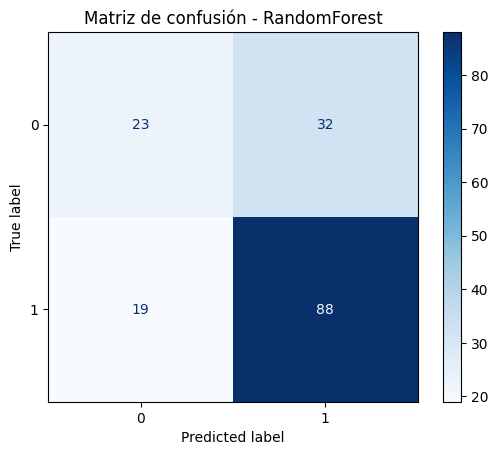

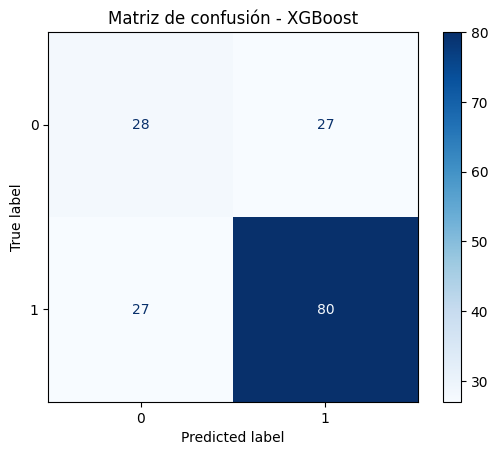

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for name, model in models_clf.items():
    if name in ['RandomForest', 'XGBoost']:
        y_pred = model.predict(X_test_clf)
        cm = confusion_matrix(y_test_clf, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Matriz de confusión - {name}")
        plt.show()

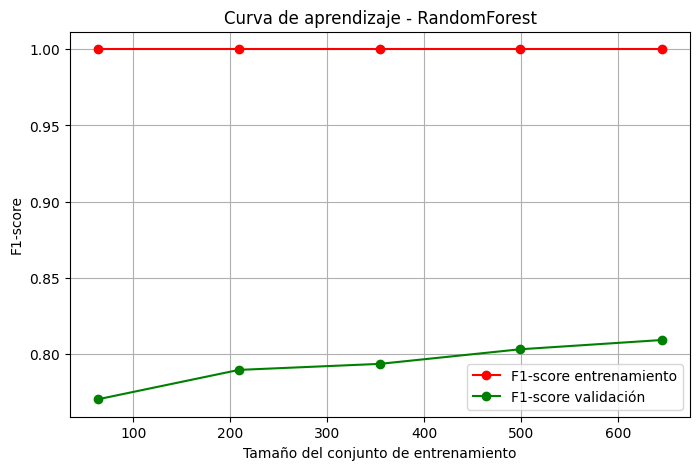

In [64]:
from sklearn.model_selection import learning_curve, StratifiedKFold
import numpy as np

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_sizes, train_scores, test_scores = learning_curve(
    models_clf['RandomForest'], X_clf, y_clf, cv=cv, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='F1-score entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='F1-score validación')
plt.title('Curva de aprendizaje - RandomForest')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('F1-score')
plt.legend(loc='best')
plt.grid()
plt.show()

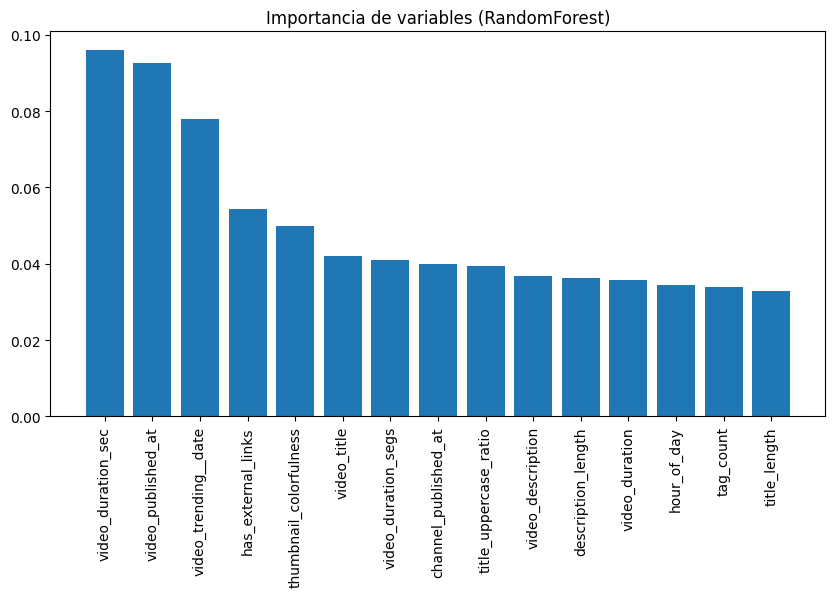

,feature,importance
23,video_duration_sec,0.096099
0,video_published_at,0.092674
1,video_trending__date,0.077981
17,has_external_links,0.054357
24,thumbnail_colorfulness,0.049824
3,video_title,0.042056
26,video_duration_segs,0.041017
8,channel_published_at,0.039980
13,title_uppercase_ratio,0.039315
4,video_description,0.036730


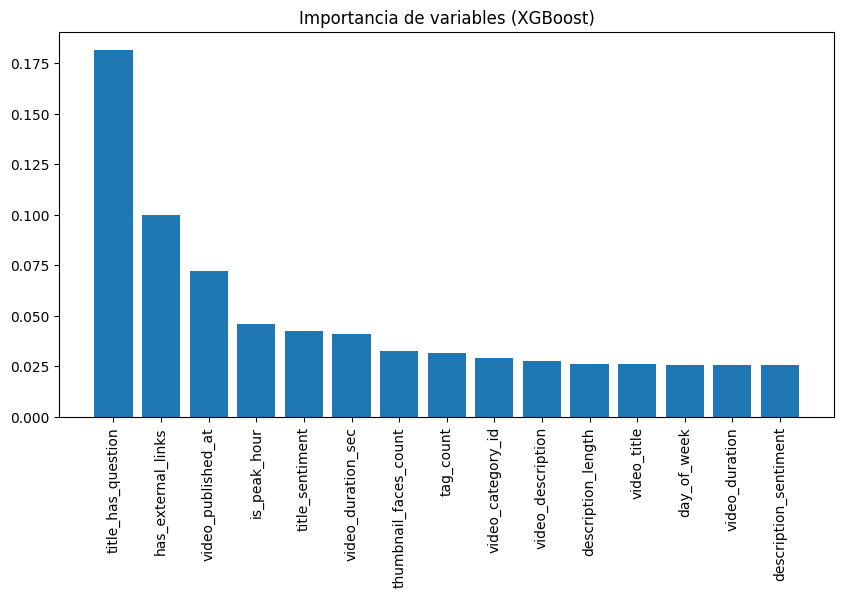

,feature,importance
12,title_has_question,0.181591
17,has_external_links,0.099738
0,video_published_at,0.072311
22,is_peak_hour,0.046114
14,title_sentiment,0.042410
23,video_duration_sec,0.040823
25,thumbnail_faces_count,0.032490
18,tag_count,0.031690
5,video_category_id,0.029261
4,video_description,0.027856


In [65]:
# Importancia de variables para RandomForest y XGBoost
import matplotlib.pyplot as plt
import pandas as pd

for name, model in models_clf.items():
    if name in ['RandomForest', 'XGBoost']:
        importances = model.feature_importances_
        features = X_train_clf.columns
        imp_df = pd.DataFrame({'feature': features, 'importance': importances}).sort_values('importance', ascending=False)
        plt.figure(figsize=(10,5))
        plt.bar(imp_df['feature'][:15], imp_df['importance'][:15])
        plt.xticks(rotation=90)
        plt.title(f'Importancia de variables ({name})')
        plt.show()
        display(imp_df.head(15))

### Optimización y ajuste de modelos
En esta sección se implementan:
- Búsqueda de hiperparámetros con GridSearchCV/RandomizedSearchCV.
- Técnicas de balanceo de clases (SMOTE y class_weight).
- Ajuste del umbral de decisión para maximizar la métrica F1.

In [66]:
# Balanceo de clases con SMOTE y ajuste de class_weight
from imblearn.over_sampling import SMOTE
from collections import Counter

# Aplicar SMOTE solo al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_clf, y_train_clf)
print('Distribución de clases tras SMOTE:', Counter(y_train_bal))

# Actualizar modelos con class_weight='balanced' donde aplica
models_bal = {
    'LogisticRegression': LogisticRegression(max_iter=500, random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
    'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal)),
    'MLPClassifier': MLPClassifier(random_state=42, max_iter=3000)
}


Distribución de clases tras SMOTE: Counter({1.0: 427, 0.0: 427})


In [67]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Hiperparámetros para RandomForest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_search = RandomizedSearchCV(RandomForestClassifier(random_state=42, class_weight='balanced'),
                              param_distributions=param_dist_rf, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
rf_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros RandomForest:', rf_search.best_params_)

# Hiperparámetros para XGBoost
param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 1.0]
}
xgb_search = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train_bal)-sum(y_train_bal))/sum(y_train_bal)),
                               param_distributions=param_dist_xgb, n_iter=10, scoring='f1', cv=3, n_jobs=-1, random_state=42)
xgb_search.fit(X_train_bal, y_train_bal)
print('Mejores hiperparámetros XGBoost:', xgb_search.best_params_)

Mejores hiperparámetros RandomForest: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': None}


c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejores hiperparámetros XGBoost: {'subsample': 1.0, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.01}


In [68]:
from sklearn.metrics import f1_score, precision_recall_curve

# Ajuste de umbral óptimo para maximizar F1-score
for name, model in zip(['RandomForest', 'XGBoost'], [rf_search.best_estimator_, xgb_search.best_estimator_]):
    model.fit(X_train_bal, y_train_bal)
    y_proba = model.predict_proba(X_test_clf)[:,1]
    precisions, recalls, thresholds = precision_recall_curve(y_test_clf, y_proba)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    print(f"\n{name} - Mejor umbral para F1: {best_threshold:.2f} (F1={f1_scores[best_idx]:.3f})")
    y_pred_opt = (y_proba >= best_threshold).astype(int)
    print(f"Reporte clasificación con umbral óptimo:\n", classification_report(y_test_clf, y_pred_opt))


RandomForest - Mejor umbral para F1: 0.48 (F1=0.816)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

         0.0       0.66      0.49      0.56        55
         1.0       0.77      0.87      0.82       107

    accuracy                           0.74       162
   macro avg       0.71      0.68      0.69       162
weighted avg       0.73      0.74      0.73       162



c:\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:19:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost - Mejor umbral para F1: 0.12 (F1=0.809)
Reporte clasificación con umbral óptimo:
               precision    recall  f1-score   support

         0.0       0.75      0.16      0.27        55
         1.0       0.69      0.97      0.81       107

    accuracy                           0.70       162
   macro avg       0.72      0.57      0.54       162
weighted avg       0.71      0.70      0.63       162

